# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostRegressor # Adaptive Boosting
from sklearn.ensemble import GradientBoostingRegressor # Gradient Tree Boosting
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import AdaBoostRegressor # Adaptive Boosting
from sklearn.ensemble import GradientBoostingRegressor # Gradient Tree Boosting

from xgboost.sklearn import XGBRegressor # Extreme Gradient Boosting
import xgboost as xgb
from scipy import stats

import utils
from utils import *


# magic word for producing visualizations in notebook
%matplotlib inline

## Part 1

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
%%time
# load in the data
azdias = pd.read_csv('azdias.csv')
azdias.drop(columns='Unnamed: 0', inplace=True)
customers = pd.read_csv('customers.csv')
customers.drop(columns='Unnamed: 0', inplace=True)

<string>:2: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 33.2 s, sys: 16 s, total: 49.2 s
Wall time: 51.4 s


In [3]:
#load the info of features and keeping only rows that contains unknown values
feature_value = pd.read_excel('attribute_values.xlsx',header=1)
feature_value.drop(columns='Unnamed: 0', inplace=True)
feature_value['Attribute']= feature_value['Attribute'].ffill()

## 1.1 Get to know dataset

**azdias**

In [4]:
azdias.shape

(891221, 366)

In [5]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


**Customers**

In [6]:
customers.shape

(191652, 369)

In [7]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


Customers has 3 extra columns which are ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'. So we drop these 3 columns that make features identical to azdias dataset

In [8]:
drop_cols = ['PRODUCT_GROUP','CUSTOMER_GROUP','ONLINE_PURCHASE']
customers.drop(columns=drop_cols, axis=1, inplace=True)
customers.shape

(191652, 366)

**Attributes**

In [9]:
print('attribute contains: {} unqiue attributes and {} columns'.format(feature_value['Attribute'].nunique(),feature_value.shape[1]))

attribute contains: 314 unqiue attributes and 4 columns


**Have a quick look at attribute_values, I noticed that there are 3 types of NaN values**
- unknown
- no transaction known 
- no transactions known
- no Online-transactions within the last 12 months<br>

**Therefore, we will have 4 dataframe: unknown_df, transaction_df, transactions_df,online_transactions_df**


>  **unknown_df**

In [10]:
unknown_df = feature_value[feature_value['Meaning']=='unknown']
unknown_df.Value.value_counts()

-1       138
-1, 9     75
-1, 0     16
0          2
-1         1
Name: Value, dtype: int64

In [11]:
# get the feature filled with 9 
unknow_feature_9list= unknown_df[unknown_df.Value.str.contains('9', na=False)].Attribute.tolist()
print('unknow_feature_9list: ',len(unknow_feature_9list))

# get the features filled with -1
type_neg1_int =unknown_df[unknown_df['Value']==-1].Attribute.tolist()
type_neg1_string = unknown_df[unknown_df['Value']=='-1'].Attribute.tolist()
unknow_feature_neg1_list=type_neg1_int+type_neg1_string
print('unknow_feature_neg1_list: ',len(unknow_feature_neg1_list))

# get features filled with 0
type_0_string= unknown_df[unknown_df.Value.str.contains('0', na=False)].Attribute.tolist()
type_0_int =  unknown_df[unknown_df['Value']==0].Attribute.tolist()
unknow_feature_0list=type_0_string+type_0_int
print('unknow_feature_0list: ',len(unknow_feature_0list))

unknow_feature_9list:  75
unknow_feature_neg1_list:  139
unknow_feature_0list:  18


> **transactions_df** 

In [12]:
transactions_df = feature_value[feature_value['Meaning']=='no transactions known']
transactions_df.Value.value_counts()

10    12
0     10
Name: Value, dtype: int64

In [13]:
#get the feature filled with 0
transactions_feature_0list = transactions_df[transactions_df['Value']==0].Attribute.tolist()
print('transactions_feature_0list: ', len(transactions_feature_0list))

#get feature filled with 10
transactions_feature_10list = transactions_df[transactions_df['Value']==10].Attribute.tolist()
print('transactions_feature_10list: ', len(transactions_feature_10list))


transactions_feature_0list:  10
transactions_feature_10list:  12


> **transaction_df**

In [14]:
transaction_df = feature_value[feature_value['Meaning']=='no transaction known']
transaction_df.Value.value_counts()

0    34
Name: Value, dtype: int64

In [15]:
#get feature filled with 0
transaction_feature_0list = transaction_df[transaction_df['Value']==0].Attribute.tolist()
print('transaction_feature_0list: ',len(transaction_feature_0list))

transaction_feature_0list:  34


> **online_transactions_df**

In [16]:
online_transactions_df = feature_value[feature_value['Meaning']=='no Online-transactions within the last 12 months']
online_transactions_df.Value.value_counts()

0    3
Name: Value, dtype: int64

In [17]:
#get feature filled with 0
online_transactions_feature_0list=online_transactions_df[online_transactions_df['Value']==0].Attribute.tolist()
print('online_transactions_feature_0list: ', len(online_transactions_feature_0list))

online_transactions_feature_0list:  3


**Now its time to find out which features in azdias and customers needed to be filled**

In [18]:
# Python program to illustrate the intersection 
# of two lists using set() method 
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2))

> **unknown_df**

In [19]:
## Azdias
unknown_columns_na_fill_neg1=intersection(azdias.columns.tolist(),unknow_feature_neg1_list)
print('unknown_columns_na_fill_neg1:',len(unknown_columns_na_fill_neg1))

unknown_columns_na_fill_9=(intersection(azdias.columns.tolist(),unknow_feature_9list))
print('unknown_columns_na_fill_9:',len(unknown_columns_na_fill_9))

unknown_columns_na_fill_0 = intersection(unknow_feature_0list, azdias.columns.tolist())
print('unknown_columns_na_fill_0:',len(unknown_columns_na_fill_0))


unknown_columns_na_fill_neg1: 134
unknown_columns_na_fill_9: 75
unknown_columns_na_fill_0: 15


> **transactions_df**

In [20]:
#azdias
transactions_columns_na_fill_0  = intersection(azdias.columns.tolist(),transactions_feature_0list)
print('transactions_columns_na_fill_0:',len(transactions_columns_na_fill_0))

transactions_columns_na_fill_10  = intersection(azdias.columns.tolist(),transactions_feature_10list)
print('transactions_columns_na_fill_10:',len(transactions_columns_na_fill_10))



transactions_columns_na_fill_0: 10
transactions_columns_na_fill_10: 12


> **transaction_df**

In [21]:
#azdias
transaction_columns_na_fill_0  = intersection(azdias.columns.tolist(),transaction_feature_0list)
print('transaction_columns_na_fill_0:',len(transaction_columns_na_fill_0))


transaction_columns_na_fill_0: 0


> **online_transactions_df**

In [22]:
online_transactions_columns_na_fill_0  = intersection(azdias.columns.tolist(),online_transactions_feature_0list)
print('online_transactions_columns_na_fill_0:',len(online_transactions_columns_na_fill_0))



online_transactions_columns_na_fill_0: 3


**SUMMARRY**<br>
There are numbers of columns which contains NaN values to be filled in azdias and customers dataset:
 - unknown_columns_na_fill_neg1: 134
 - unknown_columns_na_fill_9: 75
 - unknown_columns_na_fill_0: 15
 - transactions_columns_na_fill_0: 10
 - transactions_columns_na_fill_10: 12
 - online_transactions_columns_na_fill_0: 3

## 1.2 Get to know null data before preprocessing data

Text(0, 0.5, 'nb of null')

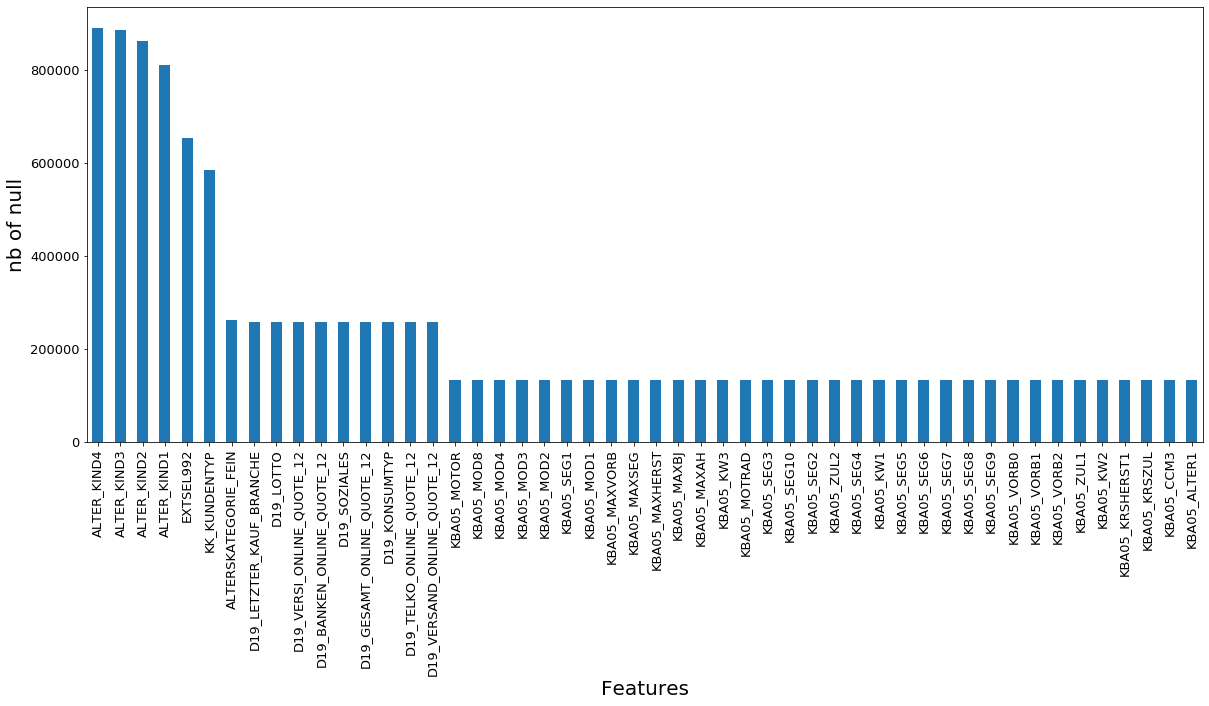

In [23]:
# get null data in azidas before processing data
azdias_null = azdias.isnull().sum()

#get top 50 features that have most null values and visuzlize
azdias_null.sort_values(ascending=False)[:50].plot(kind='bar', figsize=(20,8), fontsize=13)
plt.xlabel('Features', fontsize = 20)
plt.ylabel('nb of null', fontsize = 20)

In [24]:
#get top null percentage data in 30 columns
azdias_null_percentage = azdias_null/len(azdias) *100
print('Percentage of missing data in columns', '\n', azdias_null_percentage.sort_values(ascending=False)[:30])

Percentage of missing data in columns 
 ALTER_KIND4                    99.864792
ALTER_KIND3                    99.307691
ALTER_KIND2                    96.690047
ALTER_KIND1                    90.904837
EXTSEL992                      73.399639
KK_KUNDENTYP                   65.596749
ALTERSKATEGORIE_FEIN           29.504130
D19_LETZTER_KAUF_BRANCHE       28.849522
D19_LOTTO                      28.849522
D19_VERSI_ONLINE_QUOTE_12      28.849522
D19_BANKEN_ONLINE_QUOTE_12     28.849522
D19_SOZIALES                   28.849522
D19_GESAMT_ONLINE_QUOTE_12     28.849522
D19_KONSUMTYP                  28.849522
D19_TELKO_ONLINE_QUOTE_12      28.849522
D19_VERSAND_ONLINE_QUOTE_12    28.849522
KBA05_MOTOR                    14.959701
KBA05_MOD8                     14.959701
KBA05_MOD4                     14.959701
KBA05_MOD3                     14.959701
KBA05_MOD2                     14.959701
KBA05_SEG1                     14.959701
KBA05_MOD1                     14.959701
KBA05_MAXVORB    

columns having missing values >0%: 273 features
columns having missing values >5%: 253 features
columns having missing values >10%: 237 features
columns having missing values >15%: 16 features
columns having missing values >20%: 16 features
columns having missing values >25%: 16 features
columns having missing values >30%: 6 features
columns having missing values >35%: 6 features
columns having missing values >40%: 6 features
columns having missing values >45%: 6 features
columns having missing values >50%: 6 features
columns having missing values >55%: 6 features
columns having missing values >60%: 6 features
columns having missing values >65%: 6 features
columns having missing values >70%: 5 features
columns having missing values >75%: 4 features
columns having missing values >80%: 4 features
columns having missing values >85%: 4 features
columns having missing values >90%: 4 features
columns having missing values >95%: 3 features


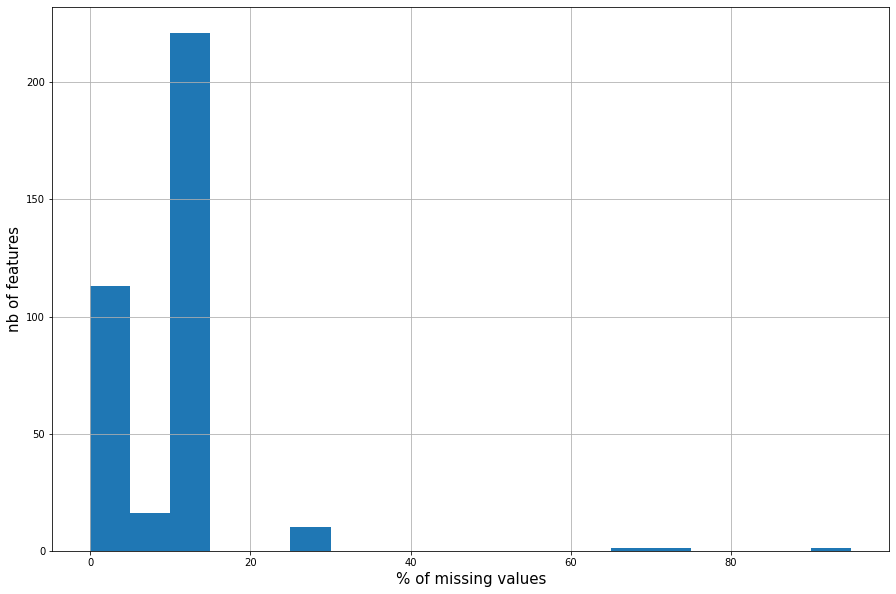

In [25]:
#We can see that % of null data in columns ranges from 0 to 15% 
azdias_null_percentage.hist(bins = np.arange(0,100,5), figsize= (15,10))
plt.xlabel('% of missing values', fontsize = 15)
plt.ylabel('nb of features', fontsize = 15)
for i in range(100):
    if i%5 == 0:
        print('columns having missing values >{}%: {} features'.format(i,len(azdias_null_percentage[azdias_null_percentage>i])))

In [26]:
print(azdias_null_percentage[azdias_null_percentage>65].index)

Index(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992',
       'KK_KUNDENTYP'],
      dtype='object')


There are 6 features that pecentage of missing values is over 65%. These columns will be dropped in data preprocessing 


In [27]:
# Now we take a look at null values in each rows 
row_nans =azdias[azdias.isnull().sum(axis=1) > 0].isnull().sum(axis=1)


Text(0, 0.5, 'Nb of rows that has null value')

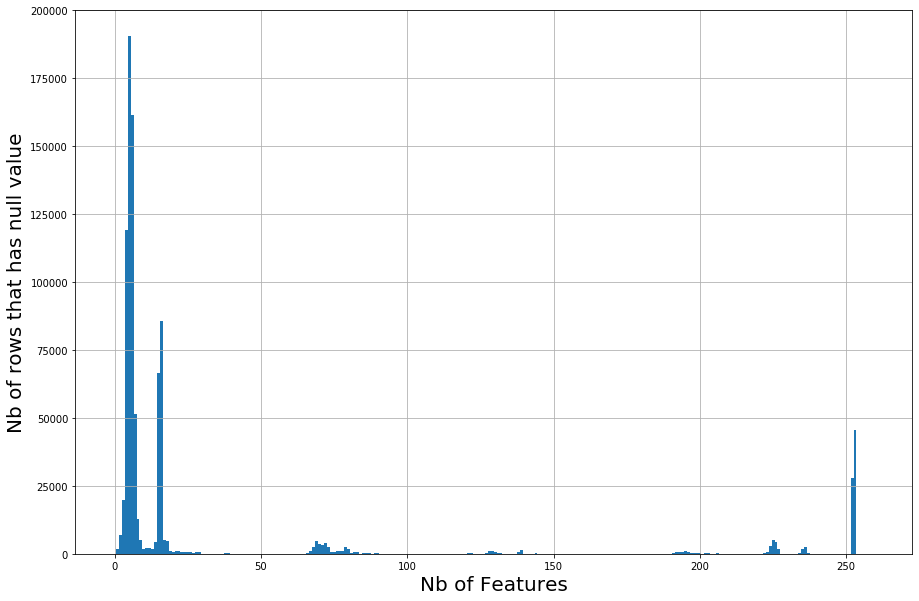

In [28]:
row_nans.hist(bins = np.arange(-0.5,row_nans.max()+1,1), figsize = (15,10))
plt.xlabel('Nb of Features', fontSize = 20)
plt.ylabel('Nb of rows that has null value', fontSize = 20)

In [29]:
for i in range(270):
    print('{} of rows missing {} features '.format((row_nans>i).sum(),i))

890919 of rows missing 0 features 
889329 of rows missing 1 features 
882341 of rows missing 2 features 
862623 of rows missing 3 features 
743425 of rows missing 4 features 
552858 of rows missing 5 features 
391259 of rows missing 6 features 
339790 of rows missing 7 features 
326917 of rows missing 8 features 
321972 of rows missing 9 features 
320251 of rows missing 10 features 
318254 of rows missing 11 features 
316218 of rows missing 12 features 
314586 of rows missing 13 features 
310280 of rows missing 14 features 
243639 of rows missing 15 features 
157994 of rows missing 16 features 
152938 of rows missing 17 features 
148405 of rows missing 18 features 
147474 of rows missing 19 features 
146916 of rows missing 20 features 
145904 of rows missing 21 features 
144989 of rows missing 22 features 
144313 of rows missing 23 features 
143585 of rows missing 24 features 
142803 of rows missing 25 features 
142294 of rows missing 26 features 
141971 of rows missing 27 features 
14

0 of rows missing 259 features 
0 of rows missing 260 features 
0 of rows missing 261 features 
0 of rows missing 262 features 
0 of rows missing 263 features 
0 of rows missing 264 features 
0 of rows missing 265 features 
0 of rows missing 266 features 
0 of rows missing 267 features 
0 of rows missing 268 features 
0 of rows missing 269 features 


**For azdias dataset, as we see above, there is slightly changes in number of rows missing values starting at 17 features. So we will keep all the rows that missing less than or equal to 17 features. The rest will be dropped. This will be done in data preprocessing**
 - 6 columns will be dropped:  'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992','KK_KUNDENTYP'
 - Rows that missing more than 17 features will be dropped

We are done analysing rows and columns, lets have a look some uneccessary features or features containing categorical values

In [30]:
azdias.dtypes.value_counts()

float64    267
int64       93
object       6
dtype: int64

In [31]:
# There are 6 total features that are non-numerical values.
#Have a look at them and decide which methods to do in data preprocessing
azdias.loc[:, azdias.dtypes=='object']

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN,NaN,NaN
1,8A,8,51,NaN,1992-02-10 00:00:00,W
2,4C,4,24,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2,12,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6,43,D19_SCHUHE,1992-02-12 00:00:00,W
...,...,...,...,...,...,...
891216,7A,7,41,D19_HAUS_DEKO,1992-02-10 00:00:00,W
891217,9D,9,51,D19_UNBEKANNT,1992-02-10 00:00:00,W
891218,4C,4,24,D19_BEKLEIDUNG_GEH,1992-02-10 00:00:00,W
891219,9D,9,51,D19_UNBEKANNT,1992-02-12 00:00:00,W


**These two features are unnecessary that contains many different items: D19_LETZTER_KAUF_BRANCHE, EINGEFUEGT_AM. These will be dropped in data preprocessing**

let's have a look another 4 non-numerical features

In [32]:
azdias['CAMEO_DEU_2015'].unique()

array([nan, '8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D',
       '5C', '8B', '7A', '5D', '9E', '9B', '1B', '3D', '4E', '4B', '3C',
       '5A', '7B', '9A', '6D', '6E', '2C', '7C', '9C', '7D', '5E', '1D',
       '8D', '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F',
       '1C', 'XX'], dtype=object)

In [33]:
azdias['CAMEO_DEUG_2015'].unique()

array([nan, 8.0, 4.0, 2.0, 6.0, 1.0, 9.0, 5.0, 7.0, 3.0, '4', '3', '7',
       '2', '8', '9', '6', '5', '1', 'X'], dtype=object)

In [34]:
azdias['CAMEO_INTL_2015'].unique()

array([nan, 51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0,
       41.0, 34.0, 55.0, 25.0, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0,
       '22', '24', '41', '12', '54', '51', '44', '35', '23', '25', '14',
       '34', '52', '55', '31', '32', '15', '13', '43', '33', '45', 'XX'],
      dtype=object)

In [35]:
azdias['OST_WEST_KZ'].unique()

array([nan, 'W', 'O'], dtype=object)

As wee save above:
- CAMEO_DEU_2015, CAMEO_INTL_2015 have unknow XX values 
- CAMEO_DEUG_2015 have unknow X values<br> 

**These values (X, XX, nan) will replace with -1 as it was describe in features description, followed by encoding**

**Summary for azdias dataset in data exploration:**
- 8 columns will be dropped: 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992','KK_KUNDENTYP', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM'
- Rows that missing more than 17 features will be dropped
- CAMEO_DEU_2015, CAMEO_INTL_2015 have unknow XX values, CAMEO_DEUG_2015 have unknow X values, which are replaced by -1 as description says
- CAMEO_DEU_2015 is categorical values which is preprocessed by get_dummies function


## 1.3 Data preprocessing

**1.3.1 Drop columns and rows**

In [36]:
#azdias
df_azdias = drop_rows_cloumns(azdias,
                           unknown_columns_na_fill_0,
                           unknown_columns_na_fill_9,
                           unknown_columns_na_fill_neg1,
                           transactions_columns_na_fill_0,
                           transactions_columns_na_fill_10,
                           online_transactions_columns_na_fill_0) 

****** Step 1 - dropping rows *****
Number of rows before dropping: 891221
Number of rows after dropping: 738283

****** Step 2 - dropping columns *****
Number of features before dropping: 366
Number of features after dropping: 357



In [37]:
df_customers = drop_rows_cloumns(customers,
                           unknown_columns_na_fill_0,
                           unknown_columns_na_fill_9,
                           unknown_columns_na_fill_neg1,
                           transactions_columns_na_fill_0,
                           transactions_columns_na_fill_10,
                           online_transactions_columns_na_fill_0) 

****** Step 1 - dropping rows *****
Number of rows before dropping: 191652
Number of rows after dropping: 131998

****** Step 2 - dropping columns *****
Number of features before dropping: 366
Number of features after dropping: 357



**Let's drop some rows and columns that have most missing values**

In [38]:
# drop rows that missing more than 17 features
# print('Number of rows before dropping: {}'.format(azdias.shape[0]))
# azdias=azdias[azdias.isnull().sum(axis=1) <= 17].reset_index(drop=True)
# print('Number of rows after dropping: {}'.format(azdias.shape[0]))

**Before dropping any columns, lets fill NaN values in each columns with 9, 0, -1 and 10**

In [39]:
# fill unknown_df
# azdias[unknown_columns_na_fill_0]=azdias[unknown_columns_na_fill_0].fillna(0)
# azdias[unknown_columns_na_fill_9]=azdias[unknown_columns_na_fill_9].fillna(9)
# azdias[unknown_columns_na_fill_neg1]=azdias[unknown_columns_na_fill_neg1].fillna(-1)

# fill transactions_df
# azdias[transactions_columns_na_fill_0]=azdias[transactions_columns_na_fill_0].fillna(0)
# azdias[transactions_columns_na_fill_10]=azdias[transactions_columns_na_fill_10].fillna(10)

# fill online_transactions_df
# azdias[online_transactions_columns_na_fill_0]=azdias[online_transactions_columns_na_fill_0].fillna(0)



**Now we drop some columns**

In [40]:
#drop 8 features: 6 features that percentage missing is over 65% 
#and 2 features that contains unnecessary different items:
# drop_cols= ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992','KK_KUNDENTYP', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM']
# print('Number of features before dropping: {}'.format(azdias.shape[1]))
# azdias.drop(drop_cols, axis=1, inplace=True)
# print('Number of features after dropping: {}'.format(azdias.shape[1]))

**1.3.2 Remove highly correlated features**

**Before we fill nan values and encode categorical values, we will use this clean up step by trying to removing highly correlated columns <br>
This step is only for clustering only, which is kept the high variance features
References:** `https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/`

In [41]:
#azdias
df_azdias_correlated=remove_highly_correlated_columns(df_azdias, 0.95)

****** Step 3 - Remove highly correlated features *****
Number of features before removing highly correlated columns: 357
Number of features after removing highly correlated columns: 348


In [42]:
#customers
df_customers_correlated=remove_highly_correlated_columns(df_customers, 0.95)

****** Step 3 - Remove highly correlated features *****
Number of features before removing highly correlated columns: 357
Number of features after removing highly correlated columns: 350


In [43]:
# %%time
# # Create correlation matrix
# corr_matrix = df_correlated_columns.corr().abs()

# # Select upper triangle of correlation matrix
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# # Find index of feature columns with correlation greater than 0.75
# to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]


In [44]:
# print('Number of features before removing highly correlated columns: {}'.format(df_correlated_columns.shape[1]))
# df_correlated_columns.drop(to_drop, axis=1, inplace=True)
# print('Number of features after removing highly correlated columns: {}'.format(df_correlated_columns.shape[1]))

**1.3.3  Encode Categorical Features**

In [45]:
#azdias
df_azdias_encode = encode(df_azdias_correlated)

****** Step 4 - Encode Categorical Features *****
number of features before encoding categorical: 348
number of features agter encoding categorical:391 



In [46]:
#customers
df_customers_encode = encode(df_customers_correlated)

****** Step 4 - Encode Categorical Features *****
number of features before encoding categorical: 350
number of features agter encoding categorical:393 



In [47]:
# CAMEO_DEU_2015, CAMEO_INTL_2015 replaced by -1
# df_encode[['CAMEO_INTL_2015','CAMEO_DEU_2015']]=df_encode[['CAMEO_INTL_2015','CAMEO_DEU_2015']].replace('XX', -1)
# df_encode['CAMEO_INTL_2015']=df_encode['CAMEO_INTL_2015'].fillna(-1)
# df_encode['CAMEO_INTL_2015']=df_encode['CAMEO_INTL_2015'].astype(int)

In [48]:
# CAMEO_DEUG_2015 replaced by -1
# df_encode['CAMEO_DEUG_2015']=df_encode['CAMEO_DEUG_2015'].replace('X', -1)
# df_encode['CAMEO_DEUG_2015']=df_encode['CAMEO_DEUG_2015'].fillna(-1)
# df_encode['CAMEO_DEUG_2015']=df_encode['CAMEO_DEUG_2015'].astype(int)

In [49]:
# NaN values OST_WEST_KZ replaced by -1, followed by encoding 1 and 2 for O and W, respectively
# df_encode['OST_WEST_KZ']=df_encode['OST_WEST_KZ'].fillna(-1)
# df_encode['OST_WEST_KZ'] = df_encode['OST_WEST_KZ'].replace({'O':1, 'W':2})

In [50]:
# df_encode['ALTER_HH']=df_encode['ALTER_HH'].fillna(0)

In [51]:
#with  all null data now handled, we should focus on getting
#objects/categorical variables to numbers via one hot encoding
# print('number of features before encoding categorical: ', df_encode.shape[1])
# df_encode = pd.get_dummies(df_encode, drop_first=True)
# print('number of features agter encoding categorical: ', df_encode.shape[1])

**1.3.4 Imputer NaN Values**

In [52]:
#azdias
df_azdias_impute = impute(df_azdias_encode)

****** Step 5 - Impute values *****
check NaN values in dataset: 0


In [53]:
#customers
df_customers_impute = impute(df_customers_encode)

****** Step 5 - Impute values *****
check NaN values in dataset: 0


In [54]:
# %%time
# impute nans using mode value
# imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
# df_impute = pd.DataFrame(imp.fit_transform(df_impute))
# print('imputed azdias: ', df_impute.head(5))

In [55]:
#check any null values
# (df_impute.isnull().sum()>0).sum()

**1.3.5 Transform data**

In [56]:
colummns_azdias = df_azdias_encode.columns
colummns_customers = df_customers_encode.columns

In [57]:
#Transform using StandardScaler
df_azdias_standard = transform(df_azdias_impute, 'StandardScaler',colummns_azdias )
df_customer_standard = transform(df_customers_impute,'StandardScaler', colummns_customers)

****** Step 6 - Transform Dataset *****
****** Step 6 - Transform Dataset *****


In [58]:
#Transform using MinMaxScaler
df_azdias_minmax = transform(df_azdias_impute, 'MinMaxScaler',colummns_azdias )
df_customer_minmax = transform(df_customers_impute,'MinMaxScaler',colummns_customers )

****** Step 6 - Transform Dataset *****
****** Step 6 - Transform Dataset *****


In [59]:
#save by using pickle 
#standard
# df_azdias_standard.to_pickle('./data/clean_azdias_standard.ppl')
# df_customer_standard.to_pickle('./data/clean_customers_standard.ppl')

#MinMaxScaler
# df_azdias_minmax.to_pickle('./data/clean_azdias_minmax.ppl')
# df_customer_minmax.to_pickle('./data/clean_customers_minmax.ppl')


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [60]:
#loading clean dataset
azdias = pd.read_pickle('data/clean_azdias_standard.ppl')
customers = pd.read_pickle('data/clean_customers_standard.ppl')

In [61]:
customers.shape

(131998, 397)

In [62]:
azdias.shape

(738283, 391)

In [63]:
#apply PCA
pca =PCA()

#fir transform dataset
azdias_pca = pca.fit_transform(azdias)

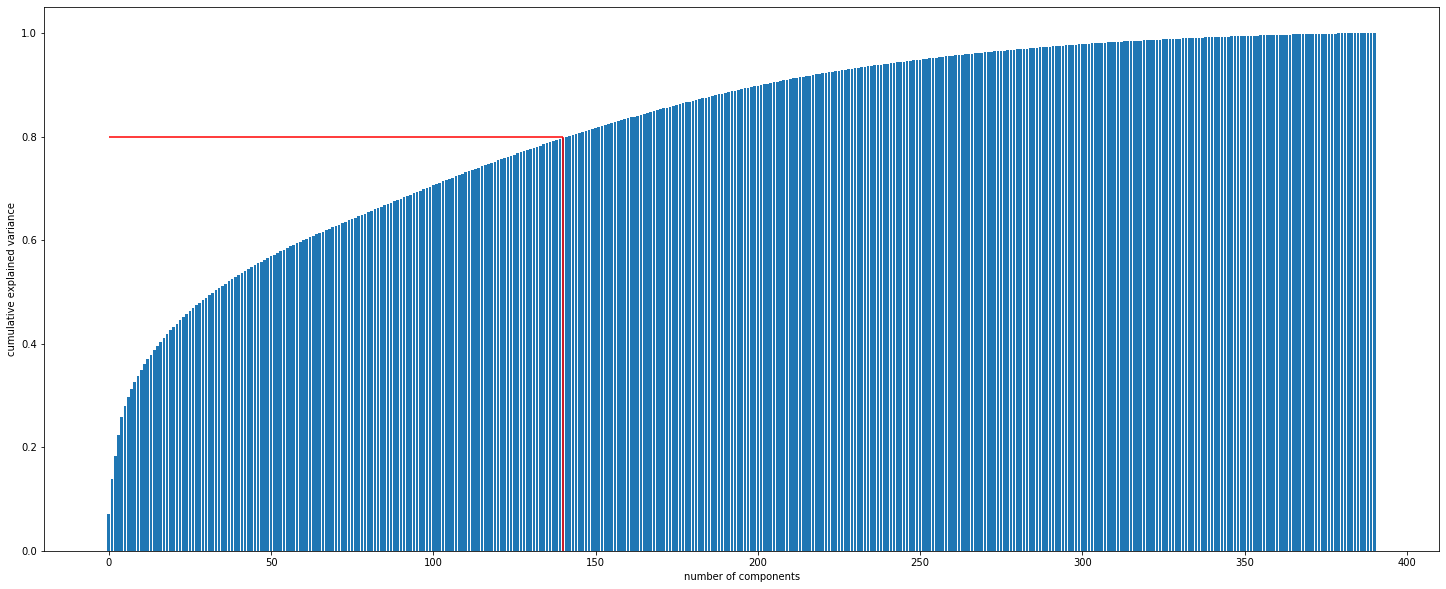

In [64]:
# Investigate the variance accounted for by each principal component.
variance = pca.explained_variance_ratio_
index = np.arange(len(variance))
plt.figure(figsize=(25,10))
plt.bar(index,np.cumsum(variance))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

#200 components
plt.hlines(y=0.8, xmin=0, xmax=140, color='red', linestyles='-',zorder=5)
plt.vlines(x=140, ymin=0, ymax=0.8, color='red', linestyles='-',zorder=6)

In [65]:
#look at the graph, 140 components cumulative up to 80% components. So we reduce our dataset to 14o features
N_COMPONENTS =140
pca_azdias = PCA(N_COMPONENTS).fit(azdias)
reduced_azdias = pd.DataFrame(pca_azdias.transform(azdias))

In [66]:
reduced_azdias.shape

(738283, 140)

In [67]:
pca_customers = PCA(N_COMPONENTS).fit(customers)
reduced_customers = pd.DataFrame(pca_customers.transform(customers))

### Component Makeup
We can now examine the makeup of each PCA component based on **the weightings of the original features that are included in the component**. The following code shows the feature-level makeup of the first component.


In [68]:
#The makeup of the principal components;
v = pd.DataFrame(pca_azdias.components_)

In [69]:
#the singular values of the components for the PCA transformation. This does not exactly give the % variance from the original feature space,
#but can give the % variance from the projected feature space.
s=pd.DataFrame(pca_azdias.explained_variance_ratio_)

In [70]:
# Calculate the explained variance for the top n principal components
# you may assume you have access to the global var N_COMPONENTS
def explained_variance(s, n_top_components):
    '''Calculates the approx. data variance that n_top_components captures.
       :param s: A dataframe of singular values for top components; 
           the top value is in the last row.
       :param n_top_components: An integer, the number of top components to use.
       :return: The expected data variance covered by the n_top_components.'''
    
    start_idx = n_top_components
    # calculate approx variance
    exp_variance = s.iloc[:start_idx, :].sum()
    return exp_variance[0]

In [71]:
# select a value for the number of top components
n_top_components = 10
# calculate the explained variance
exp_variance = explained_variance(s, n_top_components)
print('Explained variance: ', exp_variance)

Explained variance:  0.33830563699901234


In [72]:
#get the original features list 
feature_list_azdias = azdias.columns.values
feature_list_customers = customers.columns.values

In [73]:
# get the list of weights from a row in v, dataframe
def display_component(v, features_list, component_num, n_weights=10):
    row_idx = component_num
    v_1_row = v.iloc[:, row_idx]
    v_1 = np.squeeze(v_1_row.values)

    comps = pd.DataFrame(list(zip(v_1, feature_list_azdias)), columns=['weights', 'features'])
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, x="weights", y="features", palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()

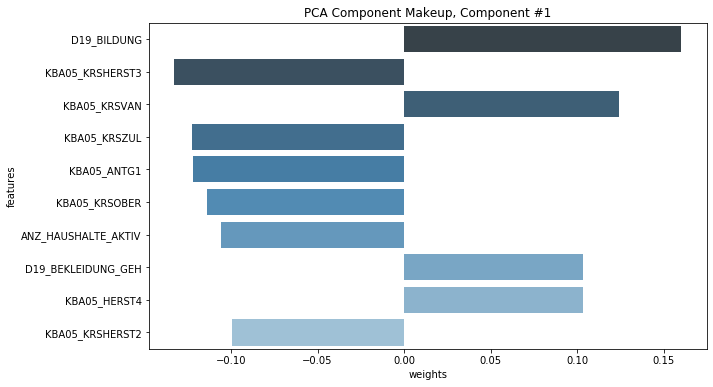

In [74]:
display_component(v,feature_list_azdias, 1)

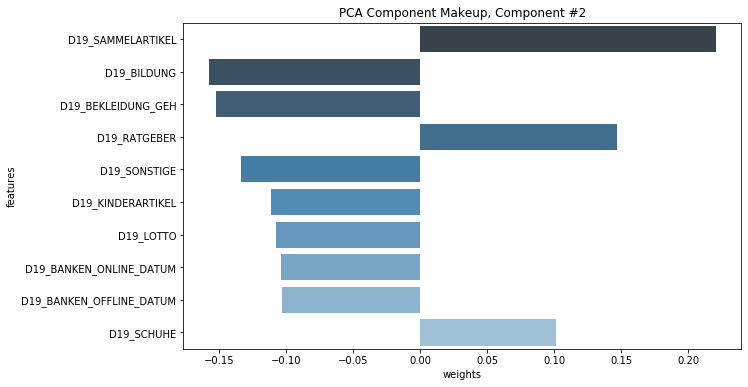

In [75]:
display_component(v,feature_list_azdias, 2)

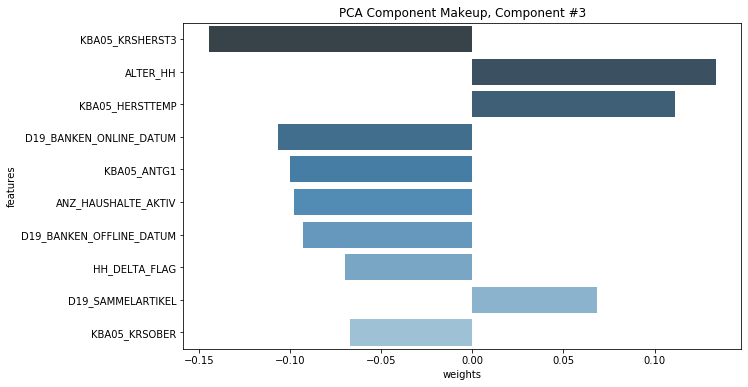

In [76]:
display_component(v,feature_list_azdias, 3)

### Interpret Principal Component
The first ten component make up 33.8% total variance of the dataset. Each component is a combination of 140 features with each feature given a weight relative to its importance for a particular principal component. The higher the weight either positive or negative, the more impact the feature has on the calculation of the principal component. What value of weight is important is subjective and depends on the context.

It's impossible to analyze 140 components. So I will take one out of 140 to ilusstruate my point in this section.
For component 1
Top 5 positive weights are:
- D19_BILDUNG: transactional activity based on the product group EDUCATION
- KBA05_HERST4: share of European manufacturer (e.g. Fiat, Peugeot, Rover,...)
- D19_BEKLEIDUNG_GEH: transactional activity based on the product group LUXURY CLOTHING
- KBA05_ALTER2: share of car owners inbetween 31 and 45 years of age
- KBA05_KRSVAN: share of vans (referred to the county average)
Top 5 negatives are:
- KBA05_HERST2: share of Volkswagen-Cars (including Audi)
- ANZ_HAUSHALTE_AKTIV:number of households in the building
- HH_EINKOMMEN_SCORE: estimated household net income 
- D19_VERSAND_ANZ_24: transaction activity MAIL-ORDER in the last 24 months
- D19_VERSICHERUNGEN: transactional activity based on the product group INSURANCES

The first component seems to represent a combination of features that relate to car manufacturing and the associated wealth in that area

### Clustering


These are steps that I did to perform clustering for both customers and general population

- Use sklearn's KMeans class to perform k-means clustering on the PCA-transformed data.

- Then, compute the average difference from each point to its assigned cluster's center. Hint: The KMeans object's .score() method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.

- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. Warning: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.

- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data

CPU times: user 3min 30s, sys: 1.42 s, total: 3min 32s
Wall time: 1min 50s


<Figure size 1080x576 with 0 Axes>

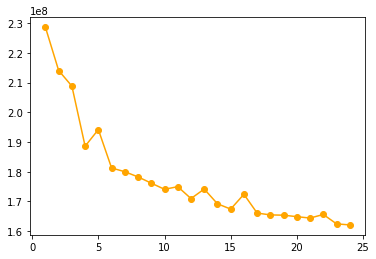

<Figure size 1080x576 with 0 Axes>

In [77]:
%%time
#elbow method
n_clusters = np.arange(1,25)
scores = [MiniBatchKMeans(i).fit(reduced_azdias).score(reduced_azdias) for i in n_clusters]
plt.plot(n_clusters, np.abs(scores), linestyle='-', marker='o', color='orange')
plt.figure(figsize=(15,8))

From the elbow method, we can see that 10 cluster might be a good final number of clusters. So we choose n_clusters = 10 to construct our model

In [78]:
%%time
#refit with 10 clusters for azdias
kmeans_k = KMeans(n_clusters=10, random_state=42)

#fit and predict azdias
prediction_azdias = kmeans_k.fit_predict(reduced_azdias)
cluster_azdias = pd.DataFrame(data=prediction_azdias)

##fit and predict customers
prediction_customers = kmeans_k.fit_predict(reduced_customers)
cluster_customers = pd.DataFrame(data = prediction_customers)

CPU times: user 5min 34s, sys: 15.1 s, total: 5min 49s
Wall time: 5min 37s


In [79]:
cluster_customers

,0
0,5
1,1
2,4
3,9
4,7
...,...
131993,7
131994,4
131995,5
131996,1


### Comparision between general population and customers 

In [80]:
cc = pd.Series(cluster_customers[0].value_counts(), name='customers')
pc = pd.Series(cluster_azdias[0].value_counts(), name='population')
df_comp = pd.concat([cc,pc], axis=1)
df_comp['diff']= df_comp['population']-df_comp['customers']
df_comp

,customers,population,diff
0,12366,96366,84000
1,16354,63610,47256
2,6615,60217,53602
3,9889,85291,75402
4,19668,109555,89887
5,23634,52058,28424
6,878,44222,43344
7,12477,103752,91275
8,19485,109728,90243
9,10632,13484,2852


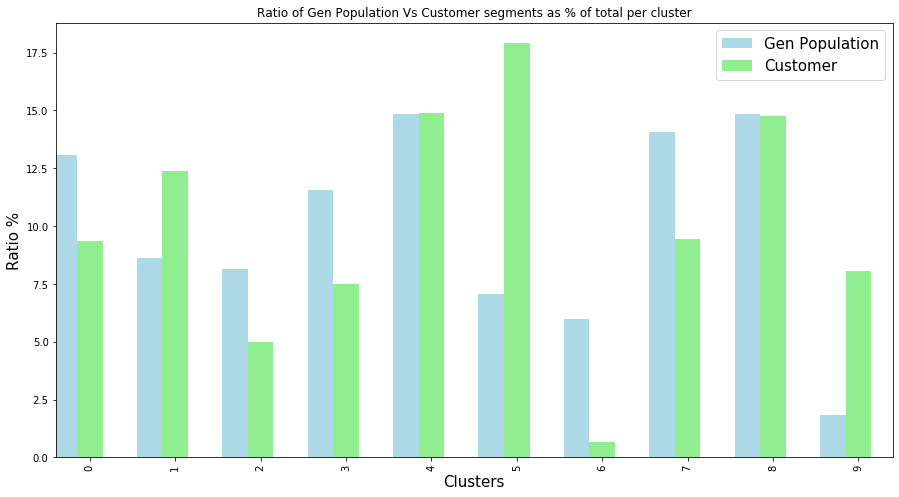

In [81]:
#Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
# Add ratio and ratio difference for each cluster to the dataframe
df_comp['population_percent'] = (df_comp['population']/df_comp['population'].sum()*100).round(2)
df_comp['customer_percent'] = (df_comp['customers']/df_comp['customers'].sum()*100).round(2)

fig = plt.figure(figsize=(15,8))

ax = fig.add_subplot(111)
ax= df_comp['population_percent'].plot(kind='bar',color='lightblue',width =-0.3, position=0 , align='edge')
ax = df_comp['customer_percent'].plot(kind='bar',color='lightgreen',width = 0.3, align='edge',position=1)
ax.set_xlabel('Clusters', fontsize=15) 
ax.set_ylabel('Ratio %', fontsize=15)
plt.legend(('Gen Population', 'Customer'),fontsize=15)
plt.title(('Ratio of Gen Population Vs Customer segments as % of total per cluster'))
plt.show()


Comparing the general and customer populations show that there are clusters that are overrepresented as well as underrepresented by the customer population.

We can observe that the three clusters with the largest amount of overrepresentation (customers) suggest that people in these clusters are more likely to be the target audience for the company. These clusters are:
- cluster 0
- cluster 1
- cluster 5
- cluster 6
- cluster 8

The three clusters that are most underrepresented are:
- cluster 2
- cluster 3
- cluster 4
- cluster 7
- cluster 9

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [82]:
mailout_train = pd.read_csv('data/mailout_train.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [83]:
X=mailout_train.drop('RESPONSE', axis=1)
y=mailout_train['RESPONSE']

In [84]:
df_train = clean_data_for_supervised_learning(X,
               unknown_columns_na_fill_0,
               unknown_columns_na_fill_9,
               unknown_columns_na_fill_neg1,
               transactions_columns_na_fill_0,
               transactions_columns_na_fill_10,
               online_transactions_columns_na_fill_0,
               1,
               'StandardScaler')

****** Step 1 - dropping columns *****
Number of features before dropping: 366
Number of features after dropping: 358

****** Step 2 - Encode Categorical Features *****
number of features before encoding categorical: 358
number of features agter encoding categorical:401 

****** Step 3 - Impute values *****
check NaN values in dataset: 0 

****** Step 4 - Transform Dataset *****
Shape after clean data: (42962, 400)
FINISH CLEAN DATASET 



In [85]:
# Split the dataset into Train/Validation/Test
X_train, X_test, y_train, y_test = train_test_split(df_train, y, test_size=0.2, random_state=42)

### Benchmark Model

The characteristic of the problem is classification problems (0 and 1), 0 which is a not customer and 1 is a customer of a company. Based on the characteristic of the problem, logistic regression is a good choice to test our data and see how they behave. Unlike linear regression, logistic regression can produce discrete binary outputs. 

In [86]:
#Algorithm to use in the optimization problem.
#For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones.
benchmark = LogisticRegression(random_state=42,
                               solver= 'saga')
benchmark.fit(X_train,y_train)
predictions = benchmark.predict(X_test)
print(f'model score:{round(roc_auc_score(y_test, predictions), 5)} \n' )

model score:0.5 



/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


The model score is quite reasonable for a simple linear model but we can improve model score by using more complex algorithm and see which one produce the best model score. Lets see if we'll use this simple model, how many scores we get on the Kaggle 

In [87]:
mailout_test = pd.read_csv('data/mailout_test.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [88]:
mailout_test_clean = clean_data_for_supervised_learning(mailout_test,
               unknown_columns_na_fill_0,
               unknown_columns_na_fill_9,
               unknown_columns_na_fill_neg1,
               transactions_columns_na_fill_0,
               transactions_columns_na_fill_10,
               online_transactions_columns_na_fill_0,
               1,
               'StandardScaler')

****** Step 1 - dropping columns *****
Number of features before dropping: 366
Number of features after dropping: 358

****** Step 2 - Encode Categorical Features *****
number of features before encoding categorical: 358
number of features agter encoding categorical:401 

****** Step 3 - Impute values *****
check NaN values in dataset: 0 

****** Step 4 - Transform Dataset *****
Shape after clean data: (42833, 400)
FINISH CLEAN DATASET 



In [89]:
prediction_for_kaggle = benchmark.predict(mailout_test_clean)
df_kaggle = pd.DataFrame(index=mailout_test['LNR'].astype('int32'), data=prediction_for_kaggle)
df_kaggle.rename(columns={0: "RESPONSE"}, inplace=True)
df_kaggle.to_csv('submission.csv')

The Kaggle score is 0.5, which is an acceptable result for a simple model but which is is quite far from the first place (>0.8). We need to choose others algorithm to improve model score.

### Model selection

XGBRegressor, GradientBoostingRegressor, AdaBoostRegressor are commonly used for regression problems. It's interesting to see what and how these algorithm works under the hood.
- AdaBoostRegressor works by weighting the observations, putting more weight on difficult to classify instances and less on those already handled well. Predictions are made by majority vote of the week learner's predictions, weighted by their individual accuracy. 
- Gradient boosting invole three elements: a loss function to be optimized, a weak learner to make predictions, an additive model to add weak learners to minimize the loss function
- XGBoost: an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way 

In [90]:
classifiers = [
    xgb.XGBRegressor(objective = 'binary:logistic'),
    GradientBoostingRegressor(random_state=42),
    AdaBoostRegressor(random_state=42)   
    ]

for classifier in classifiers:
    pipe = Pipeline(steps=[('classifier', classifier)])
    pipe.fit(X_train, y_train)   
    print(classifier)
    predictions = pipe.predict(X_test)
    print(f'model score:{round(roc_auc_score(y_test, predictions), 5)} \n' )

/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='binary:logistic',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)
model score:0.74226 

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto'

**For this project, I have tried various algorithm: XGBRegressor, GradientBoostingRegressor and AdaBoostRegressor .Although the best model score is GradientBoostingRegressor, when it comes to tune hyperparameter, the score is dropped significantly. So we will use XGBRegressor algorithmn for this model. After finding out which baseline model we are going to use, we do tunning hyperparameter to improve score**. 

### Run a baseline model without tunning

In [91]:
baseline = XGBRegressor(base_score=0.5, 
                        booster='gbtree', 
                        colsample_bytree=1, 
                        gamma=0,
                        importance_type='gain', 
                        learning_rate=0.1, 
                        max_delta_step=0,
                        max_depth=3,
                        min_child_weight=1, 
                        n_estimators=100,
                        n_jobs=1, 
                        objective='binary:logistic',
                        random_state=0,
                        reg_alpha=0, 
                        reg_lambda=1, 
                        scale_pos_weight=1,
                        subsample=1, 
                        verbosity=1,
                        scoring = 'roc_auc')
baseline.fit(X_train,y_train)
predictions = baseline.predict(X_test)
print(f'model score:{round(roc_auc_score(y_test, predictions), 5)} \n' )

/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


model score:0.74226 



Text(0, 0.5, 'Feature Importance Score')

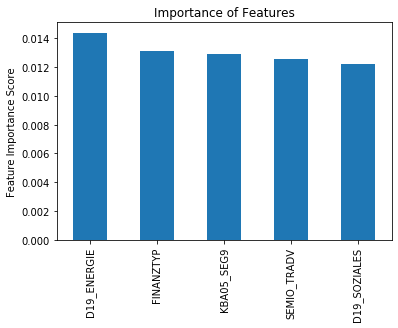

In [92]:
#list 5 feature importances
predictors=list(X_train)
feat_imp = pd.Series(baseline.feature_importances_, predictors).sort_values(ascending=False)[:5]
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')


In [93]:
XGBRegressor().get_params().keys()

dict_keys(['base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'gamma', 'importance_type', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'n_estimators', 'n_jobs', 'nthread', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'seed', 'silent', 'subsample', 'verbosity'])

## Tunning

In [ ]:
%%time
param_grid =  { 'learning_rate' : [0.1, 0.01],
                'n_estimators' :[500, 700],
                'reg_alpha' : [0.05, 0.01],
                'subsample' : [0.6, 0.5],
                'colsample_bytree' : [0.7, 0.6],
                'gamma' : [0.2, 0.3],
                'max_depth' : [5, 6],
                'min_child_weight' : [2, 3]     
              }
tuning = GridSearchCV(estimator = XGBRegressor(random_state=42, 
                                               objective='binary:logistic'),
                      param_grid =param_grid,                                                                
                      scoring = 'roc_auc',
                      n_jobs= 1,
                      cv=5)
tuning.fit(X_train, y_train) 
print(tuning.best_params_)    
print(tuning.best_score_)

**Try with few different hyperparameter**

In [ ]:
%%time
clf = xgb.XGBRegressor(objective = 'binary:logistic',
                       max_depth = 5, 
                       min_child_weight = 2,
                       learning_rate = 0.01,
                       reg_alpha = 0.05,
                       subsample = 0.6,
                       colsample_bytree = 0.7,
                       gamma = 0.2,
                       scale_pos_weight = 1,
                       random_state = 42,
                       n_estimators = 750,
                       scoring = 'roc_auc')
predictions_test = clf.fit(X_train,y_train).predict(X_test)
print(roc_auc_score(y_test, predictions_test))

In [ ]:
%%time
clf = xgb.XGBRegressor(objective = 'binary:logistic',
                       max_depth = 5, 
                       min_child_weight = 2,
                       learning_rate = 0.005,
                       reg_alpha = 0.05,
                       subsample = 0.6,
                       colsample_bytree = 0.7,
                       gamma = 0.2,
                       scale_pos_weight = 2,
                       random_state = 42,
                       n_estimators = 800,
                       scoring = 'roc_auc')
predictions_test = clf.fit(X_train,y_train).predict(X_test)
print(roc_auc_score(y_test, predictions_test))

**Final Model**

In [97]:
%%time
clf = xgb.XGBRegressor(objective = 'binary:logistic',
                       max_depth = 5, 
                       min_child_weight = 2,
                       learning_rate = 0.01,
                       reg_alpha = 0.05,
                       subsample = 0.6,
                       colsample_bytree = 0.7,
                       gamma = 0.2,
                       scale_pos_weight = 1,
                       random_state = 42,
                       n_estimators = 750,
                       scoring = 'roc_auc')
predictions_test = clf.fit(X_train,y_train).predict(X_test)
print(roc_auc_score(y_test, predictions_test))

0.7615660532702768
CPU times: user 6min 47s, sys: 648 ms, total: 6min 48s
Wall time: 6min 49s


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [98]:
mailout_test = pd.read_csv('data/mailout_test.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [99]:
mailout_test_clean = clean_data_for_supervised_learning(mailout_test,
               unknown_columns_na_fill_0,
               unknown_columns_na_fill_9,
               unknown_columns_na_fill_neg1,
               transactions_columns_na_fill_0,
               transactions_columns_na_fill_10,
               online_transactions_columns_na_fill_0,
               1,
               'StandardScaler')

****** Step 1 - dropping columns *****
Number of features before dropping: 366
Number of features after dropping: 358

****** Step 2 - Encode Categorical Features *****
number of features before encoding categorical: 358
number of features agter encoding categorical:401 

****** Step 3 - Impute values *****
check NaN values in dataset: 0 

****** Step 4 - Transform Dataset *****
Shape after clean data: (42833, 400)
FINISH CLEAN DATASET 



In [100]:
prediction_for_kaggle = clf.predict(mailout_test_clean)

In [101]:
df_kaggle = pd.DataFrame(index=mailout_test['LNR'].astype('int32'), data=prediction_for_kaggle)
df_kaggle.rename(columns={0: "RESPONSE"}, inplace=True)

In [102]:
df_kaggle.sample(10)

,RESPONSE
LNR,
5419,0.004451
68730,0.004209
19415,0.014700
4660,0.011112
74282,0.006509
48658,0.021054
25139,0.005966
61059,0.001919
45720,0.004341


In [103]:
df_kaggle.to_csv('submission.csv')

## Results
Compared to benchmark model (using logistic regression), XGBRegressor produce higher score which is above 0.8
Although XGBRegressor is not always guaranteed to be better than a logistic regression in every setting, in this case it produce competitive results. These significal results is come from:
- Wide variety of tuning parameters : XGBoost internally has parameters for cross-validation, regularization, user-defined objective functions, missing values, tree parameters, scikit-learn compatible API.
- Consistently outperforms other algorithm methods : It has shown better performance on a variety of machine learning benchmark datasets.

`XGBoost's hyperparameters`
- learning_rate: step size shrinkage used to prevent overfitting. Range is [0,1]
- max_depth: determines how deeply each tree is allowed to grow during any boosting round.
- subsample: percentage of samples used per tree. Low value can lead to underfitting.
- colsample_bytree: percentage of features used per tree. High value can lead to overfitting.
- n_estimators: number of trees you want to build.
- objective: determines the loss function to be used like reg:linear for regression problems, reg:logistic for classification problems with only decision, binary:logistic for classification problems with probability.

XGBoost also supports regularization parameters to penalize models as they become more complex and reduce them to simple (parsimonious) models.
- gamma: controls whether a given node will split based on the expected reduction in loss after the split. A higher value leads to fewer splits. Supported only for tree-based learners.